<a href="https://colab.research.google.com/github/skku-kdj/MLRobustness_eval/blob/main/art/attack/evasion/whitebox/PGD_attack_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load huggingface transformers

In [ ]:
!pip install transformers

In [ ]:
import io
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

from transformers import AutoFeatureExtractor, ResNetForImageClassification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab_Notebooks/imagenet')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/imagenet-classes.txt") as f:
  classes = [line.strip() for line in f.readlines()]
len(classes)

1000

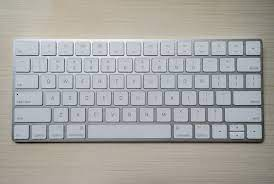

In [ ]:
image = Image.open("../data/keyboard.jpg")#make correct classified attack
image

In [ ]:
feature_extractor_resnet = AutoFeatureExtractor.from_pretrained("microsoft/resnet-18")
model_resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-18")

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [ ]:
def top5_prediction(image):
  inputs = feature_extractor_resnet(image, return_tensors="pt")
  with torch.no_grad():
    logits = model_resnet(**inputs).logits
  probabilities = logits.softmax(dim=-1)
  top5_probabilities, top5_labels = probabilities.topk(5)
  for i in range(5):
    print(f"{classes[top5_labels[0][i]]}: {top5_probabilities[0][i]*100:.2f}%")

In [ ]:
top5_prediction(image)

space bar: 76.43%
computer keyboard, keypad: 12.37%
typewriter keyboard: 8.13%
notebook, notebook computer: 0.97%
mouse, computer mouse: 0.63%


#ART attack for transformer

In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


##ProjectGradientDescent method - attack for CNN

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import HuggingFaceClassifierPyTorch

###Untargeted attack

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')



hf_classifier = HuggingFaceClassifierPyTorch(
  model = model_resnet,
  clip_values=(0, 1),
  loss=criterion,
  optimizer=optimizer,
  input_shape=(3, 224, 224),
  nb_classes=1000,
  processor=upsampler
)

In [ ]:
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
image_tensor = transform(image).unsqueeze(0)
image_numpy = image_tensor.numpy()
image_numpy.shape

(1, 3, 224, 224)

In [ ]:
attack = ProjectedGradientDescent(hf_classifier, eps=16/255, eps_step=2/255, max_iter=40, verbose=False)
adv_image_numpy = attack.generate(image_numpy)

In [ ]:
def numpy_to_img(image_numpy):
  image_numpy = image_numpy.squeeze(0)
  image_numpy = image_numpy.transpose(1, 2, 0)
  image = image_numpy * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  return image

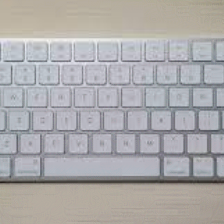

In [ ]:
adv_image = numpy_to_img(adv_image_numpy)
adv_image = Image.fromarray((adv_image * 255).astype(np.uint8))
adv_image

In [ ]:
top5_prediction(adv_image)

space bar: 60.84%
computer keyboard, keypad: 25.59%
typewriter keyboard: 7.38%
notebook, notebook computer: 1.61%
mouse, computer mouse: 0.86%


###Targeted attack

In [ ]:
attack = ProjectedGradientDescent(hf_classifier, eps=16/255, eps_step=2/255, max_iter=40, verbose=False, targeted=True)
y_target = np.array([23])
classes[23]

'vulture'

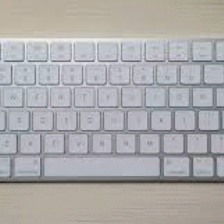

In [ ]:
t_adv_image_numpy = attack.generate(x=image_numpy, y=y_target)
t_adv_image = numpy_to_img(t_adv_image_numpy)
t_adv_image = Image.fromarray((t_adv_image * 255).astype(np.uint8))
t_adv_image

In [ ]:
top5_prediction(t_adv_image)

space bar: 61.34%
computer keyboard, keypad: 26.57%
typewriter keyboard: 6.72%
notebook, notebook computer: 1.62%
mouse, computer mouse: 0.83%


Both type of attack show bad efficiency to attack transformer. It seems vision transformer has better robustness than CNN base models.


There are some state-of-the-art attacks for vision transformer, including PatchFool. However, they are not implement on art library, so I'll try it if it is needed. These are links of github


https://github.com/GATECH-EIC/Patch-Fool?tab=readme-ov-file

https://github.com/MetaMain/ViTRobust

https://github.com/Muzammal-Naseer/ATViT